In [1]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
import os
os.chdir("c:\\Projects\\ature")
import sys
import path_config as pth
import numpy as np
import itertools as itr
from random import shuffle
from commons.segmentation import AtureTestMat, AtureTest
from PIL import Image as IMG

sep = os.sep
data_file_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'images'
av_data = pth.DATA_PATH + sep + 'av_wide_data_set'

mask_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'mask'
ground_truth_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + '1st_manual'

# for ubuntu
sys.path.append(pth.CONTEXT_PATH)
os.chdir(pth.CONTEXT_PATH)


def get_mask_file(file_name): return file_name.split('_')[0] + '_test_mask.gif'


def get_ground_truth_file(file_name): return file_name.split('_')[0] + '_manual1.gif'


SK_THRESHOLD_PARAMS = np.arange(40, 61, 20)
ALPHA_PARAMS = np.arange(5, 7, 0.5)
GABOR_CONTRIBUTION_PARAMS = np.arange(0.6, 1.1, 0.2)
SEGMENTATION_THRESHOLD_PARAMS = np.arange(9, 15, 0.5)

PARAMS_ITR = itr.product(SK_THRESHOLD_PARAMS, ALPHA_PARAMS, GABOR_CONTRIBUTION_PARAMS, SEGMENTATION_THRESHOLD_PARAMS)

PARAMS_COMBINATION = list(PARAMS_ITR)
shuffle(PARAMS_COMBINATION)

keys = ('sk_threshold', 'alpha', 'gabor_contrib', 'seg_threshold')

all_params = list(dict(zip(keys, param)) for param in PARAMS_COMBINATION)

params = {'sk_threshold': 60,
          'alpha': 6.0,
          'gabor_contrib': 1,
          'seg_threshold': 11.0}

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

### Run for image files with in-time mask erosion
tester = AtureTest(data_dir=data_file_path, log_dir=os.path.join(pth.OUT_PATH, 'out_new'))
tester.load_mask(mask_dir=mask_path, fget_mask_file=get_mask_file, erode_mask=True)
tester.load_ground_truth(ground_truth_dir=ground_truth_path, fget_ground_truth_file=get_ground_truth_file)
acc = tester.run_for_one_image(file_name='16_test.tif', params=params, save_images=True, epochs=2, alpha_decay=0.7)
# tester.run_for_all_images(params_combination=all_params)


### Run for mask fixed by Dr. Estrada
# mask_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'mask_fixed'
# tester = AtureTest(data_dir=data_file_path, log_dir=os.path.join(pth.OUT_PATH, 'out_rj'))
# tester.load_mask(mask_dir=mask_path, fget_mask_file=get_mask_file, erode_mask=False)
# tester.load_ground_truth(ground_truth_dir=ground_truth_path, fget_ground_truth_file=get_ground_truth_file)
# tester.run_for_one_image(file_name='01_test.tif', params_combination=[params], save_images=True)
# tester.run_for_all_images(params_combination=all_params)

### Run for mat files in av_wide_data_set dir
# tester = AtureTestMat(data_dir=av_data, log_dir=os.path.join(pth.OUT_PATH, 'out_ak'))
# tester.load_mask(mask_dir=mask_path, fget_mask_file=get_mask_file)
# tester.load_ground_truth(ground_truth_dir=ground_truth_path, fget_ground_truth_file=get_ground_truth_file)
# tester.run_for_one_image(file_name='wide_image_03.mat', params_combination=[params],save_images=True)


File loaded: 16_test.tif
Mask loaded: 16_test_mask.gif
Ground truth loaded: 16_manual1.gif
Lattice created
Running epoch: 0
Filter applied
Number of params combination tried: 1
Running epoch: 1
Filter applied
Number of params combination tried: 2


In [3]:
import pandas as pd
df =pd.read_csv('out/segmentation_result.csv')

In [4]:
grouped = df.groupby(['SKELETONIZE_THRESHOLD',
                      'IMG_LATTICE_COST_ASSIGNMENT_ALPHA',
                      'IMG_LATTICE_COST_GABOR_IMAGE_CONTRIBUTION',
                      'SEGMENTATION_THRESHOLD']).mean().reset_index()
grouped_sorted = grouped.sort_values(by='FSCORE', ascending=False)

In [5]:
grouped_sorted[['FSCORE','ACCURACY','PRECISION','RECALL','SKELETONIZE_THRESHOLD','IMG_LATTICE_COST_ASSIGNMENT_ALPHA',
                      'IMG_LATTICE_COST_GABOR_IMAGE_CONTRIBUTION',
                      'SEGMENTATION_THRESHOLD']]

,FSCORE,ACCURACY,PRECISION,RECALL,SKELETONIZE_THRESHOLD,IMG_LATTICE_COST_ASSIGNMENT_ALPHA,IMG_LATTICE_COST_GABOR_IMAGE_CONTRIBUTION,SEGMENTATION_THRESHOLD
244,0.75960,0.95870,0.77500,0.74980,60,6.0,1.0,11.0
204,0.75960,0.95870,0.77500,0.74980,60,5.5,1.0,9.0
283,0.75950,0.95945,0.78930,0.73695,60,6.5,1.0,12.5
243,0.75950,0.95945,0.78930,0.73695,60,6.0,1.0,10.5
285,0.75945,0.95825,0.76810,0.75620,60,6.5,1.0,13.5
284,0.75925,0.95895,0.78175,0.74355,60,6.5,1.0,13.0
100,0.75895,0.95875,0.77820,0.74600,40,6.0,1.0,11.0
60,0.75895,0.95875,0.77820,0.74600,40,5.5,1.0,9.0
141,0.75890,0.95830,0.77120,0.75220,40,6.5,1.0,13.5
139,0.75880,0.95955,0.79285,0.73285,40,6.5,1.0,12.5


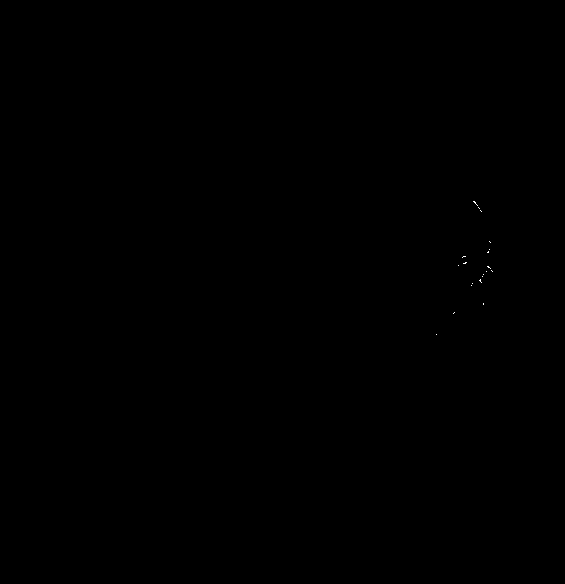

In [43]:
IMG.fromarray(255-acc.res['skeleton1'])

In [29]:
acc.res['recall1']

0.7937632170789836

In [49]:
acc.res['params0']

{'alpha': 6.0, 'gabor_contrib': 1, 'seg_threshold': 11.0, 'sk_threshold': 60}

In [51]:
acc.res['params1']

{'alpha': 5.3, 'gabor_contrib': 1, 'seg_threshold': 11.0, 'sk_threshold': 60}

In [39]:
import preprocess.utils.img_utils as ig

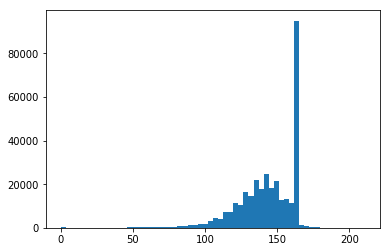

In [47]:
ig.histogram(acc.res['gabor1'], bins=60)

In [53]:
from itertools import count

In [54]:
c = count(1)

In [55]:
c

count(1)

In [56]:
next(c)

1

In [57]:
next(c)

2